In [13]:
%matplotlib inline

In [25]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sns
plt.ion()   # interactive mode
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Load Data
---------

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.


Its a cat bees dataset, constructing a transformation pipeline 


In [27]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



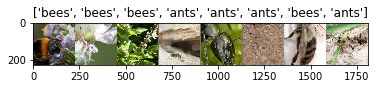

In [28]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



Basic Training Function , the scheduler is lr=0.001, decays by 0.1 every 7 epochs

In [29]:
def cyclic_weight_initialization(model,pretrained_model,alpha=1):
    
    model_state_dict=model.state_dict()
    pretrained_model_state_dict=pretrained_model.state_dict()
    for layer in model_state_dict.keys():
        
        if layer=='fc.weight' or layer=='fc.bias':
            print("skipping")
        else:
            model_state_dict[layer]=(model_state_dict[layer]+alpha*pretrained_model_state_dict[layer])/(1+alpha)
        
    #reload the state_dict of model
    model.load_state_dict(model_state_dict)
    return(model)

In [30]:
def train_model(model, pretrained_model, criterion, optimizer, scheduler, num_epochs=50,alpha=1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses=[]
    val_losses=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                print('model is training, goign to refresh its resnet memory')
                print('alpha is',alpha)
                model=cyclic_weight_initialization(model,pretrained_model,alpha)
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #print(inputs.size())
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            print('{} Rajat Best_Acc: {:.4f} Epoch_Acc: {:.4f}'.format(
                phase, best_acc, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            #collect losses
            if phase=='train':
                train_losses.append(epoch_loss)
            if phase=='val':
                val_losses.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_losses,val_losses

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [31]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            print("modi",inputs.size())
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [32]:
import pandas as pd
def plot_losses(train_loss,val_loss):
    df = pd.DataFrame(list(zip([i for i in range(0,len(train_losses))],train_loss,val_loss)), 
               columns =['epoch', 'train_loss','val_loss']) 
    list_data=[df.train_loss,df.val_loss]
    plots=sns.lineplot(data=list_data)
    return plots

In [33]:
def dump_output(model,train_loss,val_loss,experiment_name):
    model_dump_path=experiment_name+'.pt'
    torch.save(model.state_dict(),model_dump_path)
    csv_dump_path=experiment_name+'.csv'
    df = pd.DataFrame(list(zip(train_loss,val_loss)), 
           columns =[ 'train_loss','val_loss'])
    df.to_csv(csv_dump_path)
    list_data=[df.train_loss,df.val_loss]
    plot_dump_path=experiment_name+'.png'
    plots=sns.lineplot(data=list_data)
    fig=plots.get_figure()
    fig.savefig(plot_dump_path)

E1. Train whole model, LR scheduler, 100 epochs, resnet18 
----------------------------------------------------------------------------
Resnet18, train the whole model

Best val Acc: 0.960784


In [36]:
model_ft = models.resnet18(pretrained=True)
pretrained_model=models.resnet18(pretrained=True).to(device)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, pretrained_model,criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'alpha-1-cyclicweight_resnet18_lrscheduler_wholenetwork')

Epoch 0/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.5127 Acc: 0.7090
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.7090
val Loss: 0.2231 Acc: 0.9281
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9281

Epoch 1/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.3606 Acc: 0.8443
train Rajat Best_Acc: 0.9281 Epoch_Acc: 0.8443
val Loss: 0.2014 Acc: 0.9020
val Rajat Best_Acc: 0.9281 Epoch_Acc: 0.9020

Epoch 2/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2961 Acc: 0.8811
train Rajat Best_Acc: 0.9281 Epoch_Acc: 0.8811
val Loss: 0.1486 Acc: 0.9412
val Rajat Best_Acc: 0.9281 Epoch_Acc: 0.9412

Epoch 3/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2745 Acc: 0.8770
train Rajat Best_Acc: 0.9412 Epoch_Acc: 0.8770
val Loss: 0.1409 Acc: 0.9477
val Rajat 

KeyboardInterrupt: 

Epoch 0/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.5597 Acc: 0.6844
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6844
val Loss: 0.1940 Acc: 0.9412
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9412

Epoch 1/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2785 Acc: 0.8852
train Rajat Best_Acc: 0.9412 Epoch_Acc: 0.8852
val Loss: 0.1749 Acc: 0.9542
val Rajat Best_Acc: 0.9412 Epoch_Acc: 0.9542

Epoch 2/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2946 Acc: 0.8811
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.8811
val Loss: 0.1685 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 3/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.3431 Acc: 0.8689
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.8689
val Loss: 0.1433 Acc: 0.9608
val Rajat 

val Loss: 0.1638 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 32/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2771 Acc: 0.8893
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8893
val Loss: 0.1671 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 33/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2525 Acc: 0.9057
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9057
val Loss: 0.1711 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 34/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.3166 Acc: 0.8689
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8689
val Loss: 0.1660 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 35/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2772 Acc: 0.8852
train R

train Loss: 0.2617 Acc: 0.8975
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8975
val Loss: 0.1702 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 64/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2131 Acc: 0.9303
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9303
val Loss: 0.1654 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 65/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2384 Acc: 0.9180
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9180
val Loss: 0.1677 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 66/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.3351 Acc: 0.8566
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8566
val Loss: 0.1715 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 67/499
----------
model is training, goign to refresh its res

train Loss: 0.2445 Acc: 0.9057
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9057
val Loss: 0.1709 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 96/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2320 Acc: 0.9016
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9016
val Loss: 0.1666 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 97/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2905 Acc: 0.8730
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8730
val Loss: 0.1763 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 98/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2163 Acc: 0.9262
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9262
val Loss: 0.1751 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 99/499
----------
model is training, goign to refresh its res

train Loss: 0.2776 Acc: 0.8975
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8975
val Loss: 0.1729 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 128/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2583 Acc: 0.8811
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8811
val Loss: 0.1668 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 129/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2212 Acc: 0.9344
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9344
val Loss: 0.1743 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 130/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2067 Acc: 0.9221
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9221
val Loss: 0.1965 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 131/499
----------
model is training, goign to refresh its

train Loss: 0.2888 Acc: 0.8770
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8770
val Loss: 0.1660 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 160/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2273 Acc: 0.9098
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9098
val Loss: 0.1825 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 161/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.3283 Acc: 0.8689
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8689
val Loss: 0.1771 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 162/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2178 Acc: 0.9057
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9057
val Loss: 0.1618 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 163/499
----------
model is training, goign to refresh its

train Loss: 0.2249 Acc: 0.9180
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9180
val Loss: 0.1934 Acc: 0.9346
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9346

Epoch 192/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2549 Acc: 0.9098
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9098
val Loss: 0.1736 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 193/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2521 Acc: 0.9057
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9057
val Loss: 0.1669 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 194/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2495 Acc: 0.8934
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8934
val Loss: 0.1639 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 195/499
----------
model is training, goign to refresh its

train Loss: 0.2698 Acc: 0.8648
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8648
val Loss: 0.1612 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 224/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2761 Acc: 0.8770
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8770
val Loss: 0.1720 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 225/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2928 Acc: 0.8730
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8730
val Loss: 0.1802 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 226/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2921 Acc: 0.8689
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8689
val Loss: 0.1773 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 227/499
----------
model is training, goign to refresh its

train Loss: 0.2650 Acc: 0.8811
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8811
val Loss: 0.1685 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 256/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2447 Acc: 0.9139
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9139
val Loss: 0.1677 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 257/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2871 Acc: 0.8730
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8730
val Loss: 0.1645 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 258/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2179 Acc: 0.9221
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9221
val Loss: 0.1699 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 259/499
----------
model is training, goign to refresh its

train Loss: 0.2150 Acc: 0.8934
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8934
val Loss: 0.1684 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 288/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2345 Acc: 0.9139
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9139
val Loss: 0.1688 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 289/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2569 Acc: 0.9139
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9139
val Loss: 0.1699 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 290/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2278 Acc: 0.9180
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9180
val Loss: 0.1645 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 291/499
----------
model is training, goign to refresh its

train Loss: 0.2956 Acc: 0.8648
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8648
val Loss: 0.1727 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 320/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2549 Acc: 0.9016
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9016
val Loss: 0.1665 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 321/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2816 Acc: 0.8770
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8770
val Loss: 0.1659 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 322/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2653 Acc: 0.8975
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8975
val Loss: 0.1683 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 323/499
----------
model is training, goign to refresh its

train Loss: 0.2249 Acc: 0.9180
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9180
val Loss: 0.1714 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 352/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2262 Acc: 0.9303
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9303
val Loss: 0.1721 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 353/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2349 Acc: 0.9139
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9139
val Loss: 0.1693 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 354/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2556 Acc: 0.8893
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8893
val Loss: 0.1717 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 355/499
----------
model is training, goign to refresh its

train Loss: 0.2090 Acc: 0.9303
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9303
val Loss: 0.1838 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 384/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2283 Acc: 0.9221
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9221
val Loss: 0.1650 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 385/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2221 Acc: 0.9180
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9180
val Loss: 0.1707 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 386/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2283 Acc: 0.9262
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9262
val Loss: 0.1772 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 387/499
----------
model is training, goign to refresh its

train Loss: 0.2169 Acc: 0.9262
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9262
val Loss: 0.1782 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 416/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2547 Acc: 0.9098
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9098
val Loss: 0.1615 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 417/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2575 Acc: 0.9016
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9016
val Loss: 0.1571 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 418/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2640 Acc: 0.8893
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8893
val Loss: 0.1685 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 419/499
----------
model is training, goign to refresh its

train Loss: 0.2332 Acc: 0.8893
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8893
val Loss: 0.1660 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 448/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2234 Acc: 0.9057
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9057
val Loss: 0.1809 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 449/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2729 Acc: 0.8852
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8852
val Loss: 0.1638 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 450/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2279 Acc: 0.9139
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9139
val Loss: 0.1708 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 451/499
----------
model is training, goign to refresh its

train Loss: 0.2199 Acc: 0.9262
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9262
val Loss: 0.1679 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 480/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2619 Acc: 0.8934
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8934
val Loss: 0.1748 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 481/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2592 Acc: 0.8934
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8934
val Loss: 0.1744 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 482/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2042 Acc: 0.9385
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9385
val Loss: 0.1685 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 483/499
----------
model is training, goign to refresh its

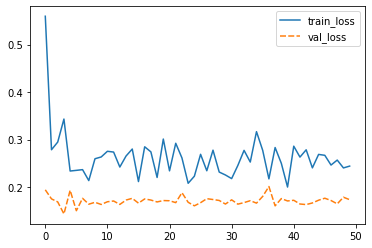

In [10]:
model_ft = models.resnet18(pretrained=True)
pretrained_model=models.resnet18(pretrained=True).to(device)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, pretrained_model,criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'alpha-1-cyclicweight_resnet18_lrscheduler_wholenetwork')

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




Epoch 0/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.4662 Acc: 0.7459
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.7459
val Loss: 0.2515 Acc: 0.9085
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9085

Epoch 1/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2523 Acc: 0.8852
train Rajat Best_Acc: 0.9085 Epoch_Acc: 0.8852
val Loss: 0.1936 Acc: 0.9216
val Rajat Best_Acc: 0.9085 Epoch_Acc: 0.9216

Epoch 2/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2463 Acc: 0.8934
train Rajat Best_Acc: 0.9216 Epoch_Acc: 0.8934
val Loss: 0.1428 Acc: 0.9542
val Rajat Best_Acc: 0.9216 Epoch_Acc: 0.9542

Epoch 3/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2999 Acc: 0.8811
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.8811
val Loss: 0.1219 Acc: 0.9281
val Rajat 

val Loss: 0.1307 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 32/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2510 Acc: 0.8934
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.8934
val Loss: 0.1343 Acc: 0.9477
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9477

Epoch 33/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2065 Acc: 0.9098
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9098
val Loss: 0.1279 Acc: 0.9477
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9477

Epoch 34/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.3021 Acc: 0.8770
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.8770
val Loss: 0.1296 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 35/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2373 Acc: 0.8975
train R

train Loss: 0.1673 Acc: 0.9467
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9467
val Loss: 0.1329 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 64/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1902 Acc: 0.9262
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9262
val Loss: 0.1407 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 65/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2442 Acc: 0.9098
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9098
val Loss: 0.1300 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 66/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2368 Acc: 0.9016
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9016
val Loss: 0.1323 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 67/499
----------
model is training, goign to refresh its res

train Loss: 0.2129 Acc: 0.9139
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9139
val Loss: 0.1326 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 96/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2273 Acc: 0.9180
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9180
val Loss: 0.1271 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 97/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2310 Acc: 0.9098
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9098
val Loss: 0.1297 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 98/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2269 Acc: 0.8934
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8934
val Loss: 0.1404 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 99/499
----------
model is training, goign to refresh its res

train Loss: 0.2523 Acc: 0.8770
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8770
val Loss: 0.1337 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 128/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2049 Acc: 0.9221
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9221
val Loss: 0.1463 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 129/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2197 Acc: 0.9180
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9180
val Loss: 0.1278 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 130/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.3011 Acc: 0.8811
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8811
val Loss: 0.1290 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 131/499
----------
model is training, goign to refresh its

train Loss: 0.2179 Acc: 0.9139
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9139
val Loss: 0.1325 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 160/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2257 Acc: 0.9221
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9221
val Loss: 0.1279 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 161/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2670 Acc: 0.8811
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8811
val Loss: 0.1316 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 162/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2239 Acc: 0.9180
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9180
val Loss: 0.1353 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 163/499
----------
model is training, goign to refresh its

train Loss: 0.2528 Acc: 0.8975
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8975
val Loss: 0.1382 Acc: 0.9412
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9412

Epoch 192/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2605 Acc: 0.8934
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8934
val Loss: 0.1348 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 193/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2212 Acc: 0.9016
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9016
val Loss: 0.1274 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 194/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2184 Acc: 0.8934
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8934
val Loss: 0.1330 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 195/499
----------
model is training, goign to refresh its

train Loss: 0.2220 Acc: 0.9262
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9262
val Loss: 0.1349 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 224/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2411 Acc: 0.8975
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8975
val Loss: 0.1296 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 225/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2462 Acc: 0.8893
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8893
val Loss: 0.1309 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 226/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2300 Acc: 0.9016
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9016
val Loss: 0.1325 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 227/499
----------
model is training, goign to refresh its

train Loss: 0.1914 Acc: 0.9262
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9262
val Loss: 0.1363 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 256/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2332 Acc: 0.9016
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9016
val Loss: 0.1372 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 257/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2457 Acc: 0.8893
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8893
val Loss: 0.1328 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 258/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2471 Acc: 0.8689
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8689
val Loss: 0.1354 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 259/499
----------
model is training, goign to refresh its

train Loss: 0.2723 Acc: 0.8852
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8852
val Loss: 0.1307 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 288/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2353 Acc: 0.9057
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9057
val Loss: 0.1362 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 289/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2386 Acc: 0.9180
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9180
val Loss: 0.1308 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 290/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2687 Acc: 0.8811
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8811
val Loss: 0.1395 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 291/499
----------
model is training, goign to refresh its

train Loss: 0.2283 Acc: 0.9180
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9180
val Loss: 0.1321 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 320/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1965 Acc: 0.9303
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9303
val Loss: 0.1262 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 321/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2517 Acc: 0.9180
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9180
val Loss: 0.1313 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 322/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2059 Acc: 0.9344
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9344
val Loss: 0.1373 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 323/499
----------
model is training, goign to refresh its

train Loss: 0.2300 Acc: 0.9139
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9139
val Loss: 0.1363 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 352/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2172 Acc: 0.9139
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9139
val Loss: 0.1316 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 353/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2145 Acc: 0.9057
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9057
val Loss: 0.1372 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 354/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2232 Acc: 0.9057
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9057
val Loss: 0.1345 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 355/499
----------
model is training, goign to refresh its

train Loss: 0.2479 Acc: 0.8852
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8852
val Loss: 0.1367 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 384/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2424 Acc: 0.9139
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9139
val Loss: 0.1299 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 385/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2695 Acc: 0.8934
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8934
val Loss: 0.1403 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 386/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2457 Acc: 0.9180
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9180
val Loss: 0.1419 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 387/499
----------
model is training, goign to refresh its

train Loss: 0.2447 Acc: 0.9016
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9016
val Loss: 0.1364 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 416/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1849 Acc: 0.9344
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9344
val Loss: 0.1385 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 417/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1926 Acc: 0.9180
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9180
val Loss: 0.1434 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 418/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2812 Acc: 0.8934
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8934
val Loss: 0.1347 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 419/499
----------
model is training, goign to refresh its

train Loss: 0.2078 Acc: 0.8975
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8975
val Loss: 0.1367 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 448/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1880 Acc: 0.9344
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9344
val Loss: 0.1415 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 449/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2271 Acc: 0.9016
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9016
val Loss: 0.1348 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 450/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2206 Acc: 0.9221
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9221
val Loss: 0.1310 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 451/499
----------
model is training, goign to refresh its

train Loss: 0.2233 Acc: 0.9057
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9057
val Loss: 0.1375 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 480/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2408 Acc: 0.9016
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9016
val Loss: 0.1349 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 481/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2276 Acc: 0.9221
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9221
val Loss: 0.1360 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 482/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2437 Acc: 0.8975
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8975
val Loss: 0.1289 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 483/499
----------
model is training, goign to refresh its

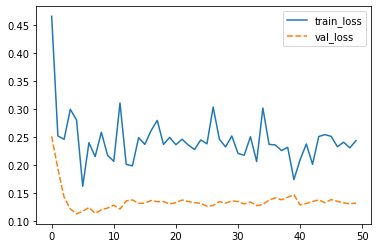

In [11]:
model_ft = models.resnet34(pretrained=True)
pretrained_model=models.resnet34(pretrained=True).to(device)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, pretrained_model,criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'alpha-1-cyclicweight_resnet34_lrscheduler_wholenetwork')

Epoch 0/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.5950 Acc: 0.6516
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6516
val Loss: 0.2180 Acc: 0.9216
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9216

Epoch 1/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.3332 Acc: 0.8525
train Rajat Best_Acc: 0.9216 Epoch_Acc: 0.8525
val Loss: 0.2323 Acc: 0.8824
val Rajat Best_Acc: 0.9216 Epoch_Acc: 0.8824

Epoch 2/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.3136 Acc: 0.8689
train Rajat Best_Acc: 0.9216 Epoch_Acc: 0.8689
val Loss: 0.1263 Acc: 0.9608
val Rajat Best_Acc: 0.9216 Epoch_Acc: 0.9608

Epoch 3/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2099 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1317 Acc: 0.9412
val Rajat 

val Loss: 0.1483 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 32/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2206 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1634 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 33/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2061 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1471 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 34/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2202 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1491 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 35/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2332 Acc: 0.9016
train R

train Loss: 0.2223 Acc: 0.8934
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8934
val Loss: 0.1422 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 64/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2474 Acc: 0.9016
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9016
val Loss: 0.1588 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 65/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2287 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1518 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 66/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1919 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1476 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 67/499
----------
model is training, goign to refresh its res

train Loss: 0.2075 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1506 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 96/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2729 Acc: 0.8893
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8893
val Loss: 0.1492 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 97/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1862 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1452 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 98/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1749 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1545 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 99/499
----------
model is training, goign to refresh its res

train Loss: 0.1919 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1435 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 128/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2330 Acc: 0.9139
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9139
val Loss: 0.1467 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 129/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2146 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1491 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 130/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2913 Acc: 0.8689
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8689
val Loss: 0.1508 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 131/499
----------
model is training, goign to refresh its

train Loss: 0.2712 Acc: 0.8730
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8730
val Loss: 0.1474 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 160/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2133 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1565 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 161/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2207 Acc: 0.9016
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9016
val Loss: 0.1562 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 162/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1705 Acc: 0.9467
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9467
val Loss: 0.1536 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 163/499
----------
model is training, goign to refresh its

train Loss: 0.1977 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1461 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 192/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2331 Acc: 0.9098
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9098
val Loss: 0.1525 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 193/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2460 Acc: 0.9098
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9098
val Loss: 0.1561 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 194/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2339 Acc: 0.9057
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9057
val Loss: 0.1534 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 195/499
----------
model is training, goign to refresh its

train Loss: 0.2222 Acc: 0.9098
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9098
val Loss: 0.1640 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 224/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2343 Acc: 0.9016
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9016
val Loss: 0.1532 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 225/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2198 Acc: 0.9098
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9098
val Loss: 0.1406 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 226/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1917 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1519 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 227/499
----------
model is training, goign to refresh its

train Loss: 0.2305 Acc: 0.9016
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9016
val Loss: 0.1446 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 256/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2221 Acc: 0.9057
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9057
val Loss: 0.1507 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 257/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2225 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1490 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 258/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2153 Acc: 0.9057
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9057
val Loss: 0.1534 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 259/499
----------
model is training, goign to refresh its

train Loss: 0.2331 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1544 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 288/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2176 Acc: 0.9139
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9139
val Loss: 0.1644 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 289/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2102 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1442 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 290/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2485 Acc: 0.8852
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8852
val Loss: 0.1493 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 291/499
----------
model is training, goign to refresh its

train Loss: 0.2548 Acc: 0.8852
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8852
val Loss: 0.1494 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 320/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2340 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1525 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 321/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2213 Acc: 0.9016
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9016
val Loss: 0.1528 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 322/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1862 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1489 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 323/499
----------
model is training, goign to refresh its

train Loss: 0.1916 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1508 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 352/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2473 Acc: 0.8852
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8852
val Loss: 0.1531 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 353/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.3027 Acc: 0.8689
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8689
val Loss: 0.1464 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 354/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2197 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1453 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 355/499
----------
model is training, goign to refresh its

train Loss: 0.2576 Acc: 0.8730
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8730
val Loss: 0.1596 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 384/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2068 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1539 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 385/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2070 Acc: 0.9098
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9098
val Loss: 0.1544 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 386/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1909 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1553 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 387/499
----------
model is training, goign to refresh its

train Loss: 0.2090 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1554 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 416/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2245 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1500 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 417/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1919 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1458 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 418/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1770 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1556 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 419/499
----------
model is training, goign to refresh its

train Loss: 0.1865 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1501 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 448/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2053 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1525 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 449/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1760 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1477 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 450/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1971 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1485 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 451/499
----------
model is training, goign to refresh its

train Loss: 0.2015 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1527 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 480/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2111 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1615 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 481/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2488 Acc: 0.9057
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9057
val Loss: 0.1490 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 482/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2062 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1525 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 483/499
----------
model is training, goign to refresh its

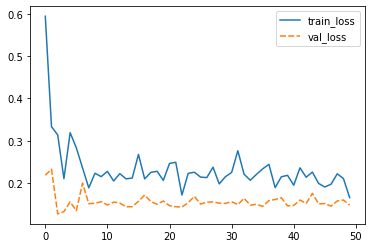

In [12]:
model_ft = models.resnet50(pretrained=True)
pretrained_model=models.resnet50(pretrained=True).to(device)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, pretrained_model,criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'alpha-1-cyclicweight_resnet50_lrscheduler_wholenetwork')

Epoch 0/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.4926 Acc: 0.7623
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.7623
val Loss: 0.2428 Acc: 0.8889
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.8889

Epoch 1/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2482 Acc: 0.9098
train Rajat Best_Acc: 0.8889 Epoch_Acc: 0.9098
val Loss: 0.1437 Acc: 0.9412
val Rajat Best_Acc: 0.8889 Epoch_Acc: 0.9412

Epoch 2/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2350 Acc: 0.9180
train Rajat Best_Acc: 0.9412 Epoch_Acc: 0.9180
val Loss: 0.1321 Acc: 0.9542
val Rajat Best_Acc: 0.9412 Epoch_Acc: 0.9542

Epoch 3/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2523 Acc: 0.9016
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9016
val Loss: 0.4081 Acc: 0.8431
val Rajat 

val Loss: 0.1460 Acc: 0.9216
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9216

Epoch 32/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1945 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1480 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 33/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2312 Acc: 0.9016
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9016
val Loss: 0.1349 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 34/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2042 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1369 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 35/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2388 Acc: 0.9016
train R

train Loss: 0.2325 Acc: 0.9057
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9057
val Loss: 0.1740 Acc: 0.9150
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9150

Epoch 64/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1871 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1471 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 65/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2255 Acc: 0.8975
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8975
val Loss: 0.1513 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 66/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2231 Acc: 0.9057
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9057
val Loss: 0.1490 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 67/499
----------
model is training, goign to refresh its res

train Loss: 0.1929 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1316 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 96/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2269 Acc: 0.9016
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9016
val Loss: 0.1578 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 97/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2045 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1370 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 98/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1965 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1557 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 99/499
----------
model is training, goign to refresh its res

train Loss: 0.1990 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1481 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 128/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1838 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1435 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 129/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2453 Acc: 0.8893
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8893
val Loss: 0.1460 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 130/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2421 Acc: 0.9016
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9016
val Loss: 0.1526 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 131/499
----------
model is training, goign to refresh its

train Loss: 0.1844 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1622 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 160/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1982 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1405 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 161/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2074 Acc: 0.9057
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9057
val Loss: 0.1346 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 162/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2161 Acc: 0.9139
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9139
val Loss: 0.2100 Acc: 0.9216
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9216

Epoch 163/499
----------
model is training, goign to refresh its

train Loss: 0.1766 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1507 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 192/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2206 Acc: 0.9057
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9057
val Loss: 0.1341 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 193/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1821 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1490 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 194/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1777 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1574 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 195/499
----------
model is training, goign to refresh its

train Loss: 0.1953 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1546 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 224/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2443 Acc: 0.8893
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8893
val Loss: 0.1497 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 225/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2068 Acc: 0.8934
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8934
val Loss: 0.1594 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 226/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2302 Acc: 0.9057
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9057
val Loss: 0.1369 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 227/499
----------
model is training, goign to refresh its

train Loss: 0.1790 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1477 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 256/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2205 Acc: 0.8975
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8975
val Loss: 0.1394 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 257/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2372 Acc: 0.8934
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8934
val Loss: 0.1621 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 258/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1662 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1461 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 259/499
----------
model is training, goign to refresh its

train Loss: 0.1912 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1465 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 288/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1600 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1505 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 289/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2569 Acc: 0.8975
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8975
val Loss: 0.1401 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 290/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2323 Acc: 0.9057
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9057
val Loss: 0.1578 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 291/499
----------
model is training, goign to refresh its

train Loss: 0.2017 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1408 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 320/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1959 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1328 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 321/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2232 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1570 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 322/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1798 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1271 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 323/499
----------
model is training, goign to refresh its

train Loss: 0.2559 Acc: 0.9057
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9057
val Loss: 0.1426 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 352/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2234 Acc: 0.9139
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9139
val Loss: 0.1491 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 353/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1916 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1646 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 354/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1467 Acc: 0.9467
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9467
val Loss: 0.1803 Acc: 0.9216
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9216

Epoch 355/499
----------
model is training, goign to refresh its

train Loss: 0.2013 Acc: 0.9139
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9139
val Loss: 0.1541 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 384/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1778 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1498 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 385/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1972 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1511 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 386/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2210 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1520 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 387/499
----------
model is training, goign to refresh its

train Loss: 0.1931 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1318 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 416/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2185 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1397 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 417/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1734 Acc: 0.9467
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9467
val Loss: 0.1318 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 418/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1990 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1539 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 419/499
----------
model is training, goign to refresh its

train Loss: 0.2316 Acc: 0.8893
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8893
val Loss: 0.1444 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 448/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2042 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1698 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 449/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2420 Acc: 0.8893
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8893
val Loss: 0.1388 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 450/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2002 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1439 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 451/499
----------
model is training, goign to refresh its

train Loss: 0.1865 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1583 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 480/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2584 Acc: 0.8852
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8852
val Loss: 0.1423 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 481/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1955 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1335 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 482/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2296 Acc: 0.9016
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9016
val Loss: 0.1572 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 483/499
----------
model is training, goign to refresh its

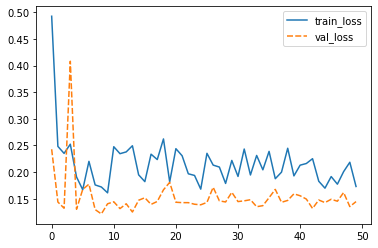

In [13]:
model_ft = models.resnet101(pretrained=True)
pretrained_model=models.resnet101(pretrained=True).to(device)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, pretrained_model,criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'alpha-1-cyclicweight_resnet101_lrscheduler_wholenetwork')

Epoch 0/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.5050 Acc: 0.7582
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.7582
val Loss: 0.2230 Acc: 0.9085
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9085

Epoch 1/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2926 Acc: 0.8770
train Rajat Best_Acc: 0.9085 Epoch_Acc: 0.8770
val Loss: 0.1138 Acc: 0.9673
val Rajat Best_Acc: 0.9085 Epoch_Acc: 0.9673

Epoch 2/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2219 Acc: 0.9303
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9303
val Loss: 0.1655 Acc: 0.9477
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9477

Epoch 3/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.3053 Acc: 0.8934
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.8934
val Loss: 0.1062 Acc: 0.9739
val Rajat 

val Loss: 0.1254 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 32/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1746 Acc: 0.9426
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9426
val Loss: 0.1228 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 33/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1688 Acc: 0.9344
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9344
val Loss: 0.1215 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 34/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1886 Acc: 0.9221
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9221
val Loss: 0.1211 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 35/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2145 Acc: 0.9262
train R

train Loss: 0.2084 Acc: 0.8852
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8852
val Loss: 0.1267 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 64/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2246 Acc: 0.8934
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8934
val Loss: 0.1186 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 65/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2117 Acc: 0.9139
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9139
val Loss: 0.1168 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 66/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2167 Acc: 0.9098
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9098
val Loss: 0.1181 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 67/499
----------
model is training, goign to refresh its res

train Loss: 0.2313 Acc: 0.9057
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9057
val Loss: 0.1181 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 96/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1757 Acc: 0.9344
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9344
val Loss: 0.1206 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 97/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1910 Acc: 0.9303
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9303
val Loss: 0.1265 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 98/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2330 Acc: 0.9098
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9098
val Loss: 0.1262 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 99/499
----------
model is training, goign to refresh its res

train Loss: 0.1983 Acc: 0.9262
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9262
val Loss: 0.1235 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 128/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2108 Acc: 0.9221
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9221
val Loss: 0.1246 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 129/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2330 Acc: 0.9057
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9057
val Loss: 0.1225 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 130/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2774 Acc: 0.8770
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.8770
val Loss: 0.1279 Acc: 0.9542
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9542

Epoch 131/499
----------
model is training, goign to refresh its

train Loss: 0.1585 Acc: 0.9508
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9508
val Loss: 0.1222 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 160/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2173 Acc: 0.9139
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9139
val Loss: 0.1251 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 161/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2150 Acc: 0.9262
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9262
val Loss: 0.1183 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 162/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1655 Acc: 0.9303
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9303
val Loss: 0.1256 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 163/499
----------
model is training, goign to refresh its

train Loss: 0.2032 Acc: 0.9139
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9139
val Loss: 0.1213 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 192/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1906 Acc: 0.9221
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9221
val Loss: 0.1210 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 193/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1930 Acc: 0.9221
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9221
val Loss: 0.1166 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 194/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1853 Acc: 0.9426
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9426
val Loss: 0.1278 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 195/499
----------
model is training, goign to refresh its

train Loss: 0.1873 Acc: 0.9262
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9262
val Loss: 0.1255 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 224/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1921 Acc: 0.9303
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9303
val Loss: 0.1229 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 225/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2076 Acc: 0.9262
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9262
val Loss: 0.1197 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 226/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1795 Acc: 0.9303
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9303
val Loss: 0.1189 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 227/499
----------
model is training, goign to refresh its

train Loss: 0.2123 Acc: 0.9180
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9180
val Loss: 0.1229 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 256/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1863 Acc: 0.9221
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9221
val Loss: 0.1203 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 257/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1982 Acc: 0.9303
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9303
val Loss: 0.1224 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 258/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2023 Acc: 0.9303
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9303
val Loss: 0.1342 Acc: 0.9542
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9542

Epoch 259/499
----------
model is training, goign to refresh its

train Loss: 0.2345 Acc: 0.9221
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9221
val Loss: 0.1151 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 288/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1525 Acc: 0.9508
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9508
val Loss: 0.1236 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 289/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2106 Acc: 0.9344
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9344
val Loss: 0.1202 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 290/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1757 Acc: 0.9262
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9262
val Loss: 0.1239 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 291/499
----------
model is training, goign to refresh its

train Loss: 0.2122 Acc: 0.9221
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9221
val Loss: 0.1166 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 320/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2286 Acc: 0.9057
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9057
val Loss: 0.1182 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 321/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2047 Acc: 0.9344
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9344
val Loss: 0.1205 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 322/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2262 Acc: 0.8852
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.8852
val Loss: 0.1200 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 323/499
----------
model is training, goign to refresh its

train Loss: 0.2490 Acc: 0.8893
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.8893
val Loss: 0.1206 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 352/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1663 Acc: 0.9508
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9508
val Loss: 0.1200 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 353/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1807 Acc: 0.9303
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9303
val Loss: 0.1251 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 354/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1934 Acc: 0.9385
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9385
val Loss: 0.1096 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 355/499
----------
model is training, goign to refresh its

train Loss: 0.1954 Acc: 0.9303
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9303
val Loss: 0.1204 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 384/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2010 Acc: 0.9057
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9057
val Loss: 0.1156 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 385/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1709 Acc: 0.9385
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9385
val Loss: 0.1201 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 386/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2068 Acc: 0.9344
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9344
val Loss: 0.1224 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 387/499
----------
model is training, goign to refresh its

train Loss: 0.1996 Acc: 0.9303
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9303
val Loss: 0.1254 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 416/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2143 Acc: 0.9385
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9385
val Loss: 0.1152 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 417/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1552 Acc: 0.9508
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9508
val Loss: 0.1278 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 418/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2276 Acc: 0.9098
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9098
val Loss: 0.1349 Acc: 0.9542
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9542

Epoch 419/499
----------
model is training, goign to refresh its

train Loss: 0.1781 Acc: 0.9426
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9426
val Loss: 0.1287 Acc: 0.9542
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9542

Epoch 448/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2435 Acc: 0.8770
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.8770
val Loss: 0.1124 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 449/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1906 Acc: 0.9385
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9385
val Loss: 0.1220 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 450/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.1645 Acc: 0.9549
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9549
val Loss: 0.1149 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 451/499
----------
model is training, goign to refresh its

train Loss: 0.2156 Acc: 0.9057
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9057
val Loss: 0.1211 Acc: 0.9542
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9542

Epoch 480/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2023 Acc: 0.9180
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9180
val Loss: 0.1243 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 481/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2322 Acc: 0.9057
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9057
val Loss: 0.1206 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 482/499
----------
model is training, goign to refresh its resnet memory
alpha is 1
skipping
skipping
train Loss: 0.2281 Acc: 0.9262
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9262
val Loss: 0.1211 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 483/499
----------
model is training, goign to refresh its

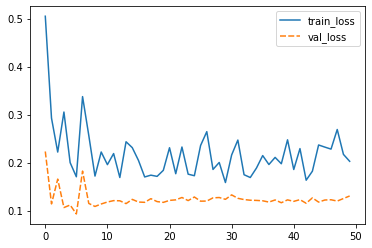

In [14]:
model_ft = models.resnet152(pretrained=True)
pretrained_model=models.resnet152(pretrained=True).to(device)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, pretrained_model,criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'alpha-1-cyclicweight_resnet152_lrscheduler_wholenetwork')